Para comprobar la hipótesis, primero importamos la librería `pandas`, que nos permite leer y manipular la base de datos, y `numpy`, que nos ayuda a trabajar con operaciones numéricas.

En esta base de datos existen varios valores atípicos. Por ello, al inicio aplicamos una **prueba de Tukey** para identificarlos y eliminamos dichos valores junto con las observaciones que contienen **NaN**.

Después, convertimos la variable **Calificación**, que originalmente está como tipo *object*, a tipo *float*. Esto es necesario para poder graficarla y analizar las observaciones con mayor facilidad.

Finalmente, generamos un gráfico de dispersión para visualizar la relación entre el Tiempo de entrega y la Calificación.

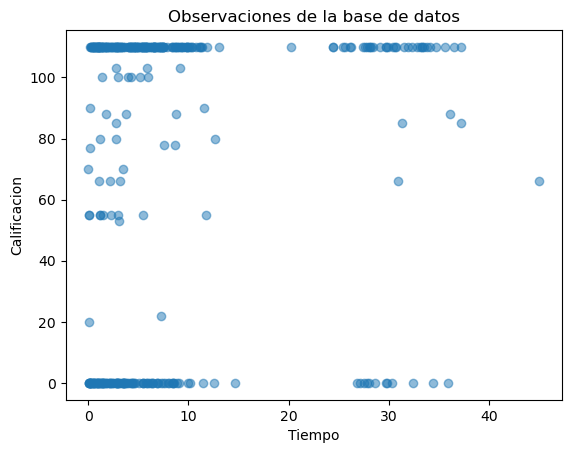

El algoritmo que debemos usar para esta distribucion de los datos es la regresión polinomial. Esto pues la relación entre las variables no es lineal y se podria representar de otra manera.


In [90]:
import pandas as pd
import numpy as np
data = pd.read_csv("Tiempo_de_Entrega.csv")
q1=data.Tiempo.quantile(0.25)
q3=data.Tiempo.quantile(0.75)
iqr=q3-q1
li=0
ls=q3+(3*iqr)
out=np.where((data.Tiempo<=li) | (data.Tiempo>=ls))[0]
data = data.drop(index=out)
data = data.dropna()
import matplotlib.pyplot as plt
%matplotlib inline
data['Calificacion'] = data['Calificacion'].apply(lambda x: 0 if not str(x).isdigit() else float(x))
plt.scatter(data.Tiempo,data.Calificacion, alpha = 0.5)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.title("Observaciones de la base de datos")
plt.show()
print("El algoritmo que debemos usar para esta distribucion de los datos es la regresión polinomial. Esto pues la relación entre las variables no es lineal y se podria representar de otra manera.")

Ahora separamos los datos en dos subconjuntos: **entrenamiento (70%)** y **prueba (30%)**. Posteriormente, calculamos el promedio de cada variable (Tiempo y Calificación) en ambos conjuntos y medimos la diferencia entre ellos.

In [92]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
X_train, X_test, Y_train, Y_test = train_test_split(data.Tiempo,data.Calificacion,train_size = 0.7)
print("Promedio del tiempo en entrenamiento:",np.mean(X_train))
print("Promedio de la calificacion en entrenamiento:",np.mean(Y_train))
print("Promedio del tiempo en prueba:",np.mean(X_test))
print("Promedio de la calificacion en prueba:",np.mean(Y_test))
print("Diferencia de los promedios del tiempo:", np.abs(np.mean(X_train) - np.mean(X_test)))
print("Diferencia de los promedios de las calificaciones:", np.abs(np.mean(Y_train) - np.mean(Y_test)))
print("\nSi los promedios son parecidos esto hace que la regresión polinomial sea mejor. Porque este tipo de regresiones son muy sensibles a cambios en la distribución.")

Promedio del tiempo en entrenamiento: 8.517588183376985
Promedio de la calificacion en entrenamiento: 69.20238095238095
Promedio del tiempo en prueba: 7.176021916577981
Promedio de la calificacion en prueba: 73.4862385321101
Diferencia de los promedios del tiempo: 1.3415662667990036
Diferencia de los promedios de las calificaciones: 4.283857579729144

Si los promedios son parecidos esto hace que la regresión polinomial sea mejor. Porque este tipo de regresiones son muy sensibles a cambios en la distribución.


Ahora construiremos tres modelos para comparar cuál predice mejor esta base. El primero será una *regresión polinomial* usando `PolynomialFeatures` de `sklearn` para generar términos no lineales de Tiempo. Después entrenamos una regresión mediante `OLS` de `statsmodels` y mostramos el resumen del modelo.

Ajustamos PolynomialFeatures solo con entrenamiento y usamos esa misma transformación para el conjunto de prueba. Usamos un polinomio de grado 9 para capturar posibles curvaturas. (Ojo: grados altos pueden sobreajustar; más adelante compararemos con otros modelos.)

In [94]:
Xtemp_train = X_train.array.reshape(-1,1)
Xtemp_test = X_test.array.reshape(-1,1)
from sklearn.preprocessing import PolynomialFeatures
poly_train = PolynomialFeatures(degree=9).fit(Xtemp_train)
poly_test = PolynomialFeatures(degree=9).fit(Xtemp_test)
X_train_poly = pd.DataFrame(poly_train.transform(Xtemp_train))
X_test_poly = pd.DataFrame(poly_test.transform(Xtemp_test))
Polymodel = sm.OLS(list(Y_train),X_train_poly).fit()
print(Polymodel.summary())
print("\nLa relacion entre el termino lineal y la respuesta es positiva, se podria decir que entre mas tiempo mas calificacion. No obstante, este valor no nos dice como se comporta el modelo en general.")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.043
Date:                Sat, 30 Aug 2025   Prob (F-statistic):             0.0422
Time:                        01:00:41   Log-Likelihood:                -1339.2
No. Observations:                 252   AIC:                             2696.
Df Residuals:                     243   BIC:                             2728.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             41.3152     15.492      2.667      0.0

Ahora entrenamos el segundo modelo con *regresión segmentada* usando `PiecewiseRegressor` de `mlinsights`. La idea es partir el eje de Tiempo en segmentos y ajustar un modelo simple en cada tramo, capturando cambios locales sin forzar un polinomio global.

In [95]:
from mlinsights.mlmodel import PiecewiseRegressor
SegmentedModel = PiecewiseRegressor('bins').fit(X_train_poly.iloc[:,1:],Y_train)

Ahora entrenamos el tercer modelo con *KNN* usando `KNeighborsRegressor` de `sklearn`. Este método predice la calificación promediando las distancias de los k vecinos más cercanos en el eje de Tiempo. Así capturamos patrones locales sin imponer una forma global como en el polinomio.

In [96]:
from sklearn.neighbors import KNeighborsRegressor as KNN
KNNmodel = KNN(n_neighbors=15).fit(Xtemp_train,Y_train)

Ahora vamos a calcular el RSE de cada uno de los modelos para poder compararlos y definir un “ganador”.

El procedimiento es:

1. Predecir los valores de prueba con cada modelo.
2. Calcular el RSS (Residual Sum of Squares) como la suma de los errores al cuadrado.
3. A partir de esto, obtener el RSE, que mide qué tan grandes son los errores promedio de predicción.

Además, agregamos un factor de interpretabilidad:

* Al modelo polinomial se le resta 3 al RSE porque es el más fácil de interpretar.
* Al modelo segmentado se le resta 1 porque es medianamente interpretable.
* Al modelo KNN no se le resta nada (0) porque es el más difícil de interpretar.

Con estos ajustes decidimos cuál es el modelo ganador: el que tenga el RSE ajustado más bajo.

In [97]:
yHat_polymodel = Polymodel.predict(X_test_poly)
RSS_polymodel = sum((list(Y_test)-yHat_polymodel)**2)
RSE_polymodel = np.sqrt(RSS_polymodel/(len(Y_test)-1))
print("Error RSE del modelo polinomial:",RSE_polymodel)
yHat_SegmentedModel = SegmentedModel.predict(X_test_poly.iloc[:,1:])
RSS_SegmentedModel = sum((list(Y_test)-yHat_SegmentedModel)**2)
RSE_SegmentedModel = np.sqrt(RSS_SegmentedModel/(len(Y_test)-1))
print("Error RSE del modelo segmentado:",RSE_SegmentedModel)
yHat_KNN = KNNmodel.predict(Xtemp_test)
RSS_KNN = sum((list(Y_test)-yHat_KNN)**2)
RSE_KNN = np.sqrt(RSS_KNN/(len(Y_test)-1))
print("Error RSE del modelo KNN:",RSE_KNN)

if (RSE_KNN-0.0 < RSE_polymodel-3.0) & (RSE_KNN-0.0 < RSE_SegmentedModel-1.0) :
    print("\nEl modelo ganador es el modelo KNN")
elif (RSE_polymodel-3.0 < RSE_KNN-0.0) & (RSE_polymodel-3.0 < RSE_SegmentedModel-1.0) :
    print("\nEl modelo ganador es el modelo polinomial")
else :
    print("\nEl modelo ganador es el modelo segmentado")

Error RSE del modelo polinomial: 49.22477413116222
Error RSE del modelo segmentado: 53.78773801212809
Error RSE del modelo KNN: 49.9562887121632

El modelo ganador es el modelo polinomial


Ahora graficamos los tres modelos junto con los datos reales de prueba para comparar visualmente qué tan cercanas son sus predicciones.

* Los puntos azules representan los datos reales (Y_test).
* Los puntos magenta corresponden al modelo segmentado.
* Los puntos rojos al modelo KNN.
* Los puntos verdes al modelo polinomial.

La idea es observar qué tan cerca están las predicciones de cada modelo respecto a los valores reales. Entre más se alineen los puntos de un modelo con los datos reales, mejor será su ajuste.

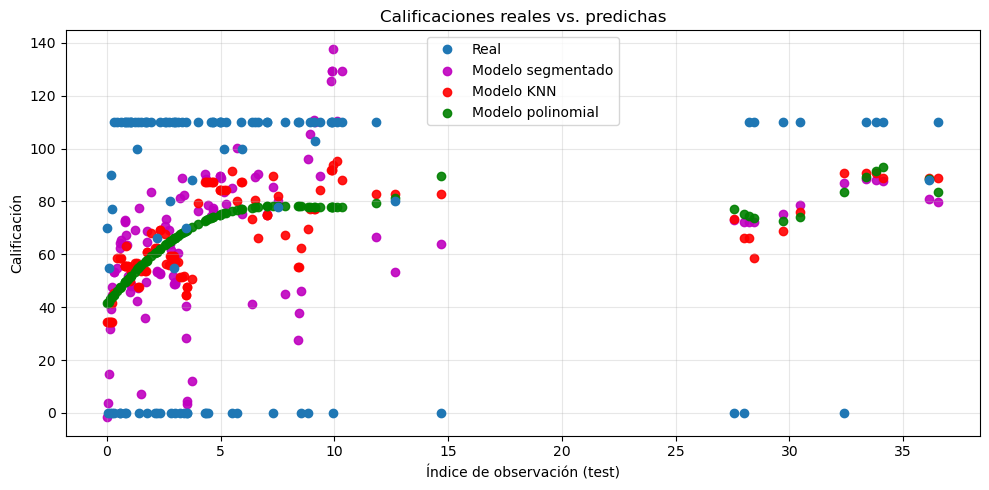

In [98]:
plt.figure(figsize=(10, 5))

plt.plot(X_test, Y_test, 'o', linewidth=2, label='Real')

plt.scatter(X_test, yHat_SegmentedModel,  marker='o',  alpha=0.9,color = 'm', label="Modelo segmentado")
plt.scatter(X_test, yHat_KNN,  marker='o',  alpha=0.9,color = 'r',label="Modelo KNN")
plt.scatter(X_test, yHat_polymodel, marker='o',  alpha=0.9,color = 'g',label="Modelo polinomial")

plt.title('Calificaciones reales vs. predichas')
plt.xlabel('Índice de observación (test)')
plt.ylabel('Calificación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como se observa en la gráfica, ninguno de los tres modelos logra representar de manera adecuada el comportamiento real de los datos. Esto se refleja en la dispersión de los puntos predichos contra los valores reales. Sin embargo, este análisis nos permite identificar áreas de mejora: se podrían probar polinomios de menor grado para evitar sobreajuste, ajustar los parámetros de KNN (como el número de vecinos), o intentar otros métodos.